In [13]:
!pip install torch torchaudio librosa transformers matplotlib soundfile --quiet

In [14]:
import torch
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [15]:
from google.colab import files
uploaded = files.upload()

audio_path = list(uploaded.keys())[0]

waveform, sample_rate = torchaudio.load(audio_path)

print("Original Sample Rate:", sample_rate)
print("Waveform Shape:", waveform.shape)

Saving LJ050-0274.wav to LJ050-0274 (1).wav
Original Sample Rate: 22050
Waveform Shape: torch.Size([1, 99229])


In [16]:
# Convert stereo to mono
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Resample to 16kHz
target_sample_rate = 16000

if sample_rate != target_sample_rate:
    resampler = torchaudio.transforms.Resample(
        orig_freq=sample_rate,
        new_freq=target_sample_rate
    )
    waveform = resampler(waveform)
    sample_rate = target_sample_rate

print("Processed Sample Rate:", sample_rate)
print("Processed Waveform Shape:", waveform.shape)

Processed Sample Rate: 16000
Processed Waveform Shape: torch.Size([1, 72003])


In [25]:
model_name = "facebook/wav2vec2-base-960h"


processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

model.eval()

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [26]:
speech = waveform.squeeze().numpy()

inputs = processor(
    speech,
    sampling_rate=sample_rate,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)[0]

In [27]:
phoneme_output = processor.batch_decode(predicted_ids.unsqueeze(0))[0]

print("Recognized Phonemes:")
print(phoneme_output)

Recognized Phonemes:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED


In [28]:
total_duration = speech.shape[0] / sample_rate
num_frames = logits.shape[1]

time_per_frame = total_duration / num_frames

tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids)

filtered_tokens = []
frame_indices = []

prev_token = None
for i, token in enumerate(tokens):
    if token != prev_token and token != processor.tokenizer.pad_token:
        filtered_tokens.append(token)
        frame_indices.append(i)
    prev_token = token

phoneme_intervals = []

for i in range(len(frame_indices)):
    start_frame = frame_indices[i]

    if i + 1 < len(frame_indices):
        end_frame = frame_indices[i + 1]
    else:
        end_frame = num_frames

    start_time = start_frame * time_per_frame
    end_time = end_frame * time_per_frame

    phoneme_intervals.append((filtered_tokens[i], start_time, end_time))

print("\nEstimated Phoneme Time Intervals:")
for p, s, e in phoneme_intervals:
    print(f"{p}: {s:.3f}s to {e:.3f}s")


Estimated Phoneme Time Intervals:
M: 0.040s to 0.121s
A: 0.121s to 0.181s
D: 0.181s to 0.221s
E: 0.221s to 0.261s
|: 0.261s to 0.382s
C: 0.382s to 0.462s
E: 0.462s to 0.482s
R: 0.482s to 0.563s
T: 0.563s to 0.623s
A: 0.623s to 0.643s
I: 0.643s to 0.683s
N: 0.683s to 0.723s
|: 0.723s to 0.804s
R: 0.804s to 0.864s
E: 0.864s to 0.924s
C: 0.924s to 0.964s
O: 0.964s to 0.984s
M: 0.984s to 1.045s
M: 1.045s to 1.105s
E: 1.105s to 1.125s
N: 1.125s to 1.185s
D: 1.185s to 1.346s
A: 1.346s to 1.426s
T: 1.426s to 1.487s
I: 1.487s to 1.567s
O: 1.567s to 1.607s
N: 1.607s to 1.708s
S: 1.708s to 1.768s
|: 1.768s to 2.290s
W: 2.290s to 2.310s
H: 2.310s to 2.371s
I: 2.371s to 2.391s
C: 2.391s to 2.411s
H: 2.411s to 2.451s
|: 2.451s to 2.511s
I: 2.511s to 2.531s
T: 2.531s to 2.572s
|: 2.572s to 2.632s
B: 2.632s to 2.692s
E: 2.692s to 2.752s
L: 2.752s to 2.833s
I: 2.833s to 2.853s
E: 2.853s to 2.913s
V: 2.913s to 2.953s
E: 2.953s to 3.014s
S: 3.014s to 3.054s
|: 3.054s to 3.174s
W: 3.174s to 3.235s
O: 3.

In [29]:
phoneme_index = 0   # Change this index if needed

phoneme_label, start_time, end_time = phoneme_intervals[phoneme_index]

start_sample = int(start_time * sample_rate)
end_sample = int(end_time * sample_rate)

phoneme_segment = speech[start_sample:end_sample]

print("\nExtracted Phoneme:", phoneme_label)
print("Start Time:", round(start_time, 3))
print("End Time:", round(end_time, 3))


Extracted Phoneme: M
Start Time: 0.04
End Time: 0.121


In [30]:
sf.write("extracted_phoneme.wav", phoneme_segment, sample_rate)

print("Extracted phoneme saved as extracted_phoneme.wav")

Extracted phoneme saved as extracted_phoneme.wav


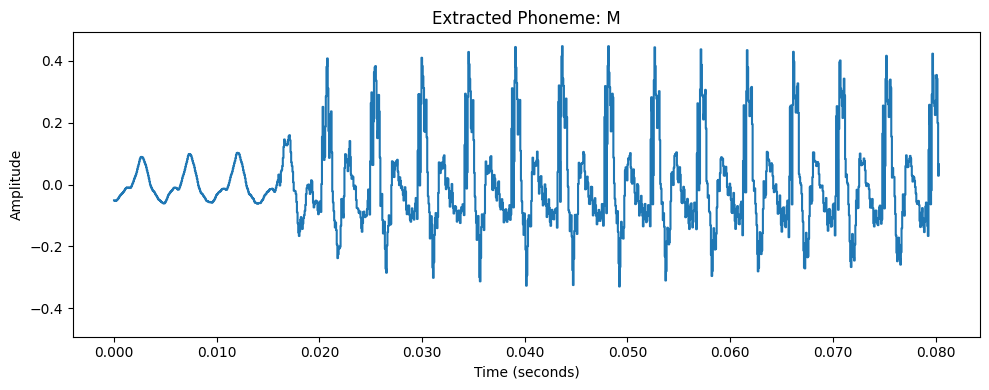

In [31]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(phoneme_segment, sr=sample_rate)
plt.title(f"Extracted Phoneme: {phoneme_label}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [32]:
zcr = librosa.feature.zero_crossing_rate(phoneme_segment)[0]
mean_zcr = np.mean(zcr)

print("Mean Zero Crossing Rate:", mean_zcr)

if mean_zcr < 0.1:
    print("Inference: Voiced sound (vowel/nasal). Vocal cords vibrate.")
else:
    print("Inference: Unvoiced sound (fricative/plosive). Air turbulence dominant.")

Mean Zero Crossing Rate: 0.054850260416666664
Inference: Voiced sound (vowel/nasal). Vocal cords vibrate.
